In [49]:
import pandas as pd
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import joblib
from bertopic import BERTopic

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [2]:
# Download latest version
path = kagglehub.dataset_download("jithinanievarghese/cosmetics-and-beauty-products-reviews-top-brands")

print("Path to dataset files:", path)

100%|██████████| 4.55M/4.55M [00:01<00:00, 3.45MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jithinanievarghese/cosmetics-and-beauty-products-reviews-top-brands/versions/1


Explorer les fichiers téléchargés

In [3]:
# Afficher le chemin
print("Chemin du dataset :", path)

# Lister les fichiers disponibles
os.listdir(path)

Chemin du dataset : /root/.cache/kagglehub/datasets/jithinanievarghese/cosmetics-and-beauty-products-reviews-top-brands/versions/1


['nyka_top_brands_cosmetics_product_reviews.csv']

Chargement du fichier csv sur les retours des utilisateurs

In [4]:
import os

# The 'path' variable is a directory. We need to specify the exact file within it.
file_name = 'nyka_top_brands_cosmetics_product_reviews.csv'
full_file_path = os.path.join(path, file_name)

df = pd.read_csv(full_file_path, encoding='latin1')

In [5]:
df.head()

,product_id,brand_name,review_id,review_title,review_text,author,review_date,review_rating,is_a_buyer,pro_user,review_label,product_title,mrp,price,product_rating,product_rating_count,product_tags,product_url
0,781070,Olay,16752142,Worth buying 50g one,Works as it claims. Could see the difference f...,Ashton Dsouza,2021-01-23 15:17:18,5.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...
1,781070,Olay,14682550,Best cream to start ur day,It does what it claims . Best thing is it smoo...,Amrit Neelam,2020-09-07 15:30:42,5.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...
2,781070,Olay,15618995,perfect for summers dry for winters,I have been using this product for months now....,Sanchi Gupta,2020-11-13 12:24:14,4.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...
3,781070,Olay,13474509,Not a moisturizer,"i have an oily skin, while this whip acts as a...",Ruchi Shah,2020-06-14 11:56:50,3.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...
4,781070,Olay,16338982,Average,It's not that good. Please refresh try for oth...,Sukanya Sarkar,2020-12-22 15:24:35,2.0,True,False,Verified Buyer,Olay Ultra Lightweight Moisturiser: Luminous W...,1999,1599,4.1,43,NaN,https://www.nykaa.com/olay-ultra-lightweight-m...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61284 entries, 0 to 61283
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   product_id            61284 non-null  int64  
 1   brand_name            61284 non-null  object 
 2   review_id             61284 non-null  int64  
 3   review_title          61284 non-null  object 
 4   review_text           61275 non-null  object 
 5   author                61284 non-null  object 
 6   review_date           61284 non-null  object 
 7   review_rating         61283 non-null  float64
 8   is_a_buyer            61284 non-null  bool   
 9   pro_user              61284 non-null  bool   
 10  review_label          48249 non-null  object 
 11  product_title         61284 non-null  object 
 12  mrp                   61284 non-null  int64  
 13  price                 61284 non-null  int64  
 14  product_rating        61284 non-null  float64
 15  product_rating_coun

Analyse du Dataset

In [7]:
#Taille du dataset
print("Taille du dataset :", df.shape)

Taille du dataset : (61284, 18)


In [8]:
#Supprimer des colonnes
df.drop(['author', 'is_a_buyer', 'pro_user', 'review_label', 'price', 'mrp', 'product_url', 'product_rating_count', 'product_rating', 'product_tags'], axis=1, inplace=True)
df.head()

,product_id,brand_name,review_id,review_title,review_text,review_date,review_rating,product_title
0,781070,Olay,16752142,Worth buying 50g one,Works as it claims. Could see the difference f...,2021-01-23 15:17:18,5.0,Olay Ultra Lightweight Moisturiser: Luminous W...
1,781070,Olay,14682550,Best cream to start ur day,It does what it claims . Best thing is it smoo...,2020-09-07 15:30:42,5.0,Olay Ultra Lightweight Moisturiser: Luminous W...
2,781070,Olay,15618995,perfect for summers dry for winters,I have been using this product for months now....,2020-11-13 12:24:14,4.0,Olay Ultra Lightweight Moisturiser: Luminous W...
3,781070,Olay,13474509,Not a moisturizer,"i have an oily skin, while this whip acts as a...",2020-06-14 11:56:50,3.0,Olay Ultra Lightweight Moisturiser: Luminous W...
4,781070,Olay,16338982,Average,It's not that good. Please refresh try for oth...,2020-12-22 15:24:35,2.0,Olay Ultra Lightweight Moisturiser: Luminous W...


##Charger et explorer (EDA) : longueurs de texte, distribution des labels, mots fréquents

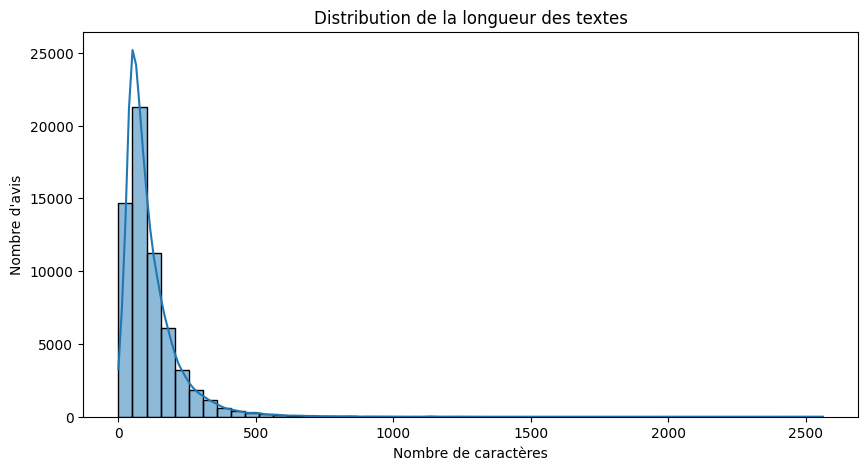

In [9]:
# --- 3a : Longueur des textes ---
# Convertir la colonne 'review_text' en string et remplacer les NaN par des chaînes vides avant de calculer la longueur
df['text_length'] = df['review_text'].astype(str).apply(len)

plt.figure(figsize=(10,5))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution de la longueur des textes")
plt.xlabel("Nombre de caractères")
plt.ylabel("Nombre d'avis")
plt.show()

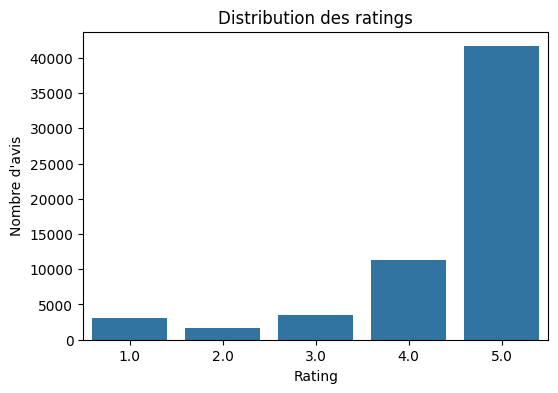

In [10]:
# --- 3b : Distribution des labels ---
plt.figure(figsize=(6,4))
sns.countplot(x='review_rating', data=df)
plt.title("Distribution des ratings")
plt.xlabel("Rating")
plt.ylabel("Nombre d'avis")
plt.show()

20 mots les plus fréquents :
the: 45425
it: 44883
and: 42637
is: 34855
i: 30598
a: 30065
this: 28077
for: 25214
to: 21789
my: 15835
good: 15206
very: 15002
its: 14345
product: 13301
of: 12355
but: 12139
so: 11298
in: 10946
with: 10346
skin: 10249


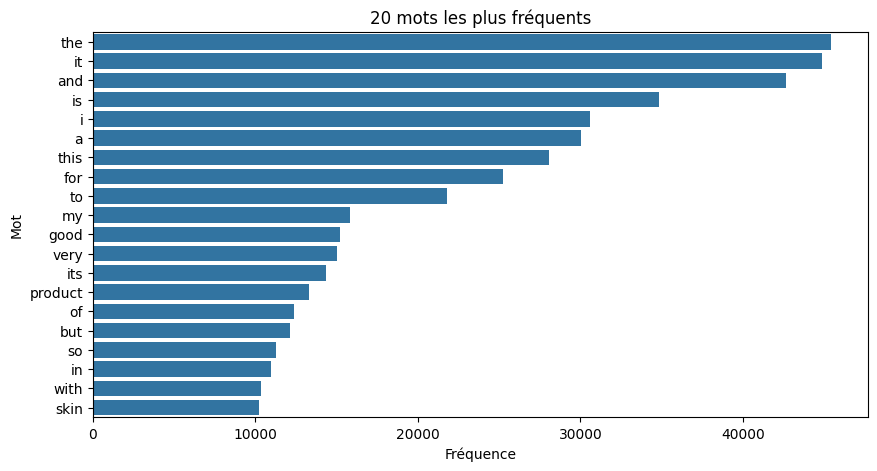

In [11]:
# On nettoie le texte et on compte les mots
def tokenize(review_text):
    review_text = review_text.lower()
    review_text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', review_text)  # retirer ponctuation
    return review_text.split()

# Ensure all text entries are strings and handle NaNs before tokenizing
processed_texts = df['review_text'].fillna('').astype(str)
all_words = [word for text in processed_texts for word in tokenize(text)]
most_common_words = Counter(all_words).most_common(20)

print("20 mots les plus fréquents :")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

# Optionnel : histogramme des mots fréquents
words, counts = zip(*most_common_words)
plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words))
plt.title("20 mots les plus fréquents")
plt.xlabel("Fréquence")
plt.ylabel("Mot")
plt.show()

##Supprimer les lignes vides ou doublons

In [12]:
# Supprimer avis sans texte
df = df.dropna(subset=["review_text"])

# Supprimer doublons si nécessaire
df = df.drop_duplicates(subset=["review_text"])
df.head()

,product_id,brand_name,review_id,review_title,review_text,review_date,review_rating,product_title,text_length
0,781070,Olay,16752142,Worth buying 50g one,Works as it claims. Could see the difference f...,2021-01-23 15:17:18,5.0,Olay Ultra Lightweight Moisturiser: Luminous W...,107
1,781070,Olay,14682550,Best cream to start ur day,It does what it claims . Best thing is it smoo...,2020-09-07 15:30:42,5.0,Olay Ultra Lightweight Moisturiser: Luminous W...,88
2,781070,Olay,15618995,perfect for summers dry for winters,I have been using this product for months now....,2020-11-13 12:24:14,4.0,Olay Ultra Lightweight Moisturiser: Luminous W...,177
3,781070,Olay,13474509,Not a moisturizer,"i have an oily skin, while this whip acts as a...",2020-06-14 11:56:50,3.0,Olay Ultra Lightweight Moisturiser: Luminous W...,218
4,781070,Olay,16338982,Average,It's not that good. Please refresh try for oth...,2020-12-22 15:24:35,2.0,Olay Ultra Lightweight Moisturiser: Luminous W...,57


Nettoyage du texte

Pour NLP, il faut uniformiser et simplifier le texte :

Mettre en minuscules

Retirer ponctuation, chiffres, symboles

Retirer espaces multiples

Éventuellement retirer stopwords (mots très fréquents comme “le”, “et”, “de”) si besoin pour l’extraction de thématiques

In [13]:
def clean_text(text):
    text = text.lower()  # minuscules
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)  # retirer ponctuation et chiffres
    text = re.sub(r'\s+', ' ', text)  # retirer espaces multiples
    text = text.strip()
    return text

df['clean_text'] = df['review_text'].apply(clean_text)


In [14]:
#Nettoyage pour review_title
def clean_text(text):
    text = str(text).lower()  # minuscules
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)  # retirer ponctuation et chiffres
    text = re.sub(r'\s+', ' ', text)  # retirer espaces multiples
    text = text.strip()
    return text

df['clean_review_title'] = df['review_title'].apply(clean_text)


##Création du label de sentiment

In [15]:
def rating_to_sentiment(r):
    if r >= 4:
        return "positif"
    elif r == 3:
        return "neutre"
    else:
        return "negatif"

df['sentiment'] = df['review_rating'].apply(rating_to_sentiment)


Nettoyage final et vérification

In [16]:
# Vérifier les valeurs nulles
print(df.isnull().sum())

# Aperçu des données
print(df.head())


product_id            0
brand_name            0
review_id             0
review_title          0
review_text           0
review_date           0
review_rating         1
product_title         0
text_length           0
clean_text            0
clean_review_title    0
sentiment             0
dtype: int64
   product_id brand_name  review_id                         review_title  \
0      781070       Olay   16752142                 Worth buying 50g one   
1      781070       Olay   14682550           Best cream to start ur day   
2      781070       Olay   15618995  perfect for summers dry for winters   
3      781070       Olay   13474509                    Not a moisturizer   
4      781070       Olay   16338982                              Average   

                                         review_text          review_date  \
0  Works as it claims. Could see the difference f...  2021-01-23 15:17:18   
1  It does what it claims . Best thing is it smoo...  2020-09-07 15:30:42   
2  I have b

#Prétraitement NLP

In [17]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))  # ou 'french' si dataset français
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return ' '.join(tokens)

df['processed_text'] = df['clean_text'].apply(preprocess)
df['processed_title'] = df['clean_review_title'].apply(preprocess)
df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


,product_id,brand_name,review_id,review_title,review_text,review_date,review_rating,product_title,text_length,clean_text,clean_review_title,sentiment,processed_text,processed_title
0,781070,Olay,16752142,Worth buying 50g one,Works as it claims. Could see the difference f...,2021-01-23 15:17:18,5.0,Olay Ultra Lightweight Moisturiser: Luminous W...,107,works as it claims could see the difference fr...,worth buying g one,positif,work claim could see difference first day use ...,worth buying g one
1,781070,Olay,14682550,Best cream to start ur day,It does what it claims . Best thing is it smoo...,2020-09-07 15:30:42,5.0,Olay Ultra Lightweight Moisturiser: Luminous W...,88,it does what it claims best thing is it smooth...,best cream to start ur day,positif,claim best thing smoothens ur skin n make soft...,best cream start ur day
2,781070,Olay,15618995,perfect for summers dry for winters,I have been using this product for months now....,2020-11-13 12:24:14,4.0,Olay Ultra Lightweight Moisturiser: Luminous W...,177,i have been using this product for months now ...,perfect for summers dry for winters,positif,using product month perfect combination n oily...,perfect summer dry winter
3,781070,Olay,13474509,Not a moisturizer,"i have an oily skin, while this whip acts as a...",2020-06-14 11:56:50,3.0,Olay Ultra Lightweight Moisturiser: Luminous W...,218,i have an oily skin while this whip acts as a ...,not a moisturizer,neutre,oily skin whip act great base primer smoothens...,moisturizer
4,781070,Olay,16338982,Average,It's not that good. Please refresh try for oth...,2020-12-22 15:24:35,2.0,Olay Ultra Lightweight Moisturiser: Luminous W...,57,its not that good please refresh try for other...,average,negatif,good please refresh try product,average


In [18]:
#Convertir review_date en datatime
df['review_date'] = pd.to_datetime(df['review_date'])

Vectorisation : transformer les textes en format utilisable par un modèle ML :

TF-IDF pour un modèle classique (Logistic Regression, Random Forest)

Embeddings pour un modèle deep learning (Word2Vec, FastText, BERT, etc.)

In [19]:
vectorizer = TfidfVectorizer(max_features=10000)  # limite du vocabulaire

# Nous allons maintenant séparer les données avant la vectorisation TF-IDF
# pour s'adapter à une future utilisation de modèles comme BERT.
# Les variables X et y seront créées après le split.


In [20]:
# Séparer les données textuelles (non encore vectorisées) et les labels
X_raw = df['processed_text']
y = df['sentiment']

# Splitter les données en ensembles d'entraînement et de test AVANT vectorisation
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X_raw, y, test_size=0.2, random_state=42)

# Fitter le vectoriseur UNIQUEMENT sur les données d'entraînement et transformer les deux ensembles
X_train = vectorizer.fit_transform(X_train_raw)
X_test = vectorizer.transform(X_test_raw)


Entrainement du modèle de Régression Logistique

In [21]:
#Entrainement Logistic regression

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


              precision    recall  f1-score   support

     negatif       0.76      0.52      0.62       937
      neutre       0.44      0.08      0.13       695
     positif       0.91      0.99      0.95     10335

    accuracy                           0.90     11967
   macro avg       0.70      0.53      0.57     11967
weighted avg       0.87      0.90      0.87     11967



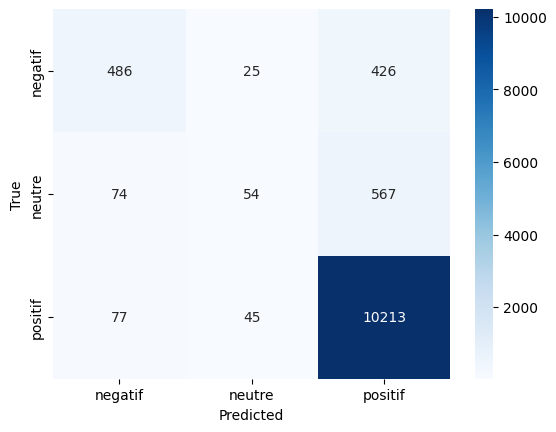

In [22]:
#Evaluation des métriques
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Entrainement du modèle naive_bayes

In [23]:
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train)
y_pred_nb = model_nb.predict(X_test)

              precision    recall  f1-score   support

     negatif       0.92      0.13      0.23       937
      neutre       0.00      0.00      0.00       695
     positif       0.87      1.00      0.93     10335

    accuracy                           0.87     11967
   macro avg       0.60      0.38      0.39     11967
weighted avg       0.83      0.87      0.82     11967



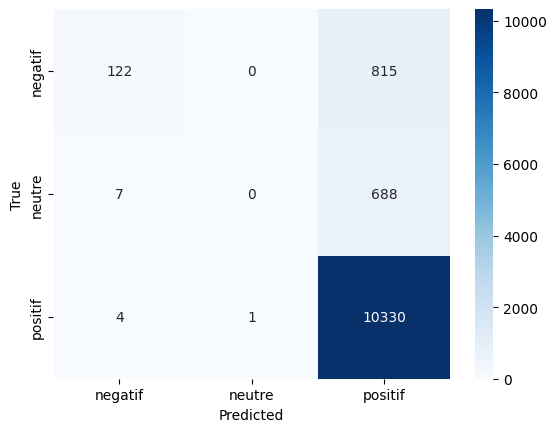

In [24]:
#Evaluation des métriques
print(classification_report(y_test, y_pred_nb))

cm = confusion_matrix(y_test, y_pred_nb)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=model.classes_,
            yticklabels=model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

##Entrainement de BERT
Objectif

Utiliser un modèle BERT pré-entraîné pour classer tes avis clients (positif / neutre / négatif), sans fine-tuning complet, car tu n’as pas de GPU.

In [33]:
#Prétraitement — Tokenisation avec BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

encodings = tokenizer(
    df['processed_text'].tolist(),
    padding=True,
    truncation=True,
    max_length=128,
    return_tensors='pt'
)

In [41]:
# Étape 4 — Créer le Dataset PyTorch
class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Mapper les labels de sentiment en entiers
label_mapping = {'negatif': 0, 'neutre': 1, 'positif': 2}
labels = df['sentiment'].map(label_mapping).values

dataset = ReviewDataset(encodings, labels)

# Étape 5 — Séparer et créer les DataLoaders
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)


Ici, on utilise BertForSequenceClassification, c’est BERT + une petite couche linéaire ajoutée pour prédire un label.

In [36]:
#Entrainement BERT

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


#Entraînement (fine-tuning)

In [38]:
epochs = 3  # Définir le nombre d'époques pour l'entraînement
optimizer = AdamW(model.parameters(), lr=2e-5)
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * epochs
)

In [39]:
model.eval()


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
#Faire les prédictions
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

all_preds = []
all_labels = []

# Désactiver le calcul des gradients (plus rapide, moins de RAM)
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']

        # Si tu es sur Colab avec GPU
        if torch.cuda.is_available():
            input_ids = input_ids.cuda()
            attention_mask = attention_mask.cuda()
            labels = labels.cuda()
            model.cuda()

        # Prédiction
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits

        # Conversion en classes prédites
        preds = torch.argmax(logits, dim=1)

        # Stocker les résultats
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [43]:
print(classification_report(all_labels, all_preds, target_names=['négatif', 'neutre', 'positif']))


              precision    recall  f1-score   support

     négatif       0.07      0.04      0.05       934
      neutre       0.00      0.00      0.00       708
     positif       0.86      0.95      0.91     10325

    accuracy                           0.83     11967
   macro avg       0.31      0.33      0.32     11967
weighted avg       0.75      0.83      0.79     11967



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


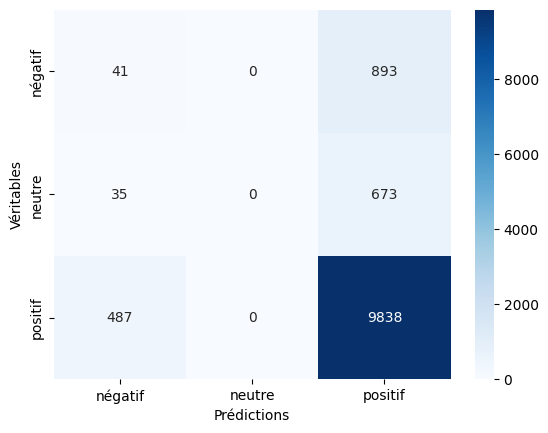

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['négatif', 'neutre', 'positif'],
            yticklabels=['négatif', 'neutre', 'positif'])
plt.xlabel('Prédictions')
plt.ylabel('Véritables')
plt.show()


In [47]:
#Sauvegarder le modèle de régression logistique

joblib.dump(model, 'model_logisticregression.pkl')

# Sauvegarde du vectorizer (TF-IDF)
joblib.dump(vectorizer, 'vectorizer_tfidf.pkl')

print("Modèle et vectorizer sauvegardés avec succès !")

Modèle et vectorizer sauvegardés avec succès !


##Extraction de thématiques avec BERTopic

In [48]:
!pip install bertopic[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 11.7 MB/s eta 0:00:00


In [50]:
#Liste de textes à fournir à BERTopic
df['combined_text'] = df['processed_title'] + " " + df['processed_text']
documents = df['combined_text'].tolist()

In [51]:
#Créer et entraîner le modèle BERTopic

topic_model = BERTopic(language="english")
topics, probabilities = topic_model.fit_transform(documents)

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [52]:
#Top 10 thèmes
# -------------------------------
topic_info = topic_model.get_topic_info()
top10_topics = topic_info.head(10)
print("🔹 Top 10 thèmes :")
print(top10_topics)

🔹 Top 10 thèmes :
   Topic  Count                                     Name  \
0     -1  19702               -1_shade_lip_skin_lipstick   
1      0   6886         0_hair_shampoo_conditioner_scalp   
2      1   1251         1_perfume_fragrance_smell_strong   
3      2   1013               2_kajal_smudge_black_proof   
4      3    810     3_foundation_hydrating_coverage_dewy   
5      4    722        4_powder_loose_banana_translucent   
6      5    714               5_blush_blusher_cheek_rosy   
7      6    637  6_pigmentation_pigmented_pigment_highly   
8      7    528            7_pimple_acne_patch_overnight   
9      8    515       8_glitter_glittery_particle_chunky   

                                      Representation  \
0  [shade, lip, skin, lipstick, tone, look, liner...   
1  [hair, shampoo, conditioner, scalp, frizzy, he...   
2  [perfume, fragrance, smell, strong, floral, ma...   
3  [kajal, smudge, black, proof, kajals, lakme, s...   
4  [foundation, hydrating, coverage, dewy

In [53]:
#Mots-clés par thème
# -------------------------------
print("\n🔹 Mots-clés par thème (top 10 mots pour chaque thème) :")
for t in top10_topics['Topic']:
    if t != -1:  # -1 = outliers / non assignés
        print(f"\nThème {t} : {topic_model.get_topic(t)}")




🔹 Mots-clés par thème (top 10 mots pour chaque thème) :

Thème 0 : [('hair', np.float64(0.015005024949586963)), ('shampoo', np.float64(0.013703852560394676)), ('conditioner', np.float64(0.011977266405424715)), ('scalp', np.float64(0.008550312587215515)), ('frizzy', np.float64(0.008360700603463396)), ('herbal', np.float64(0.00767184320661633)), ('essence', np.float64(0.006830071999077503)), ('wash', np.float64(0.006785544359442649)), ('smell', np.float64(0.006235206015581548)), ('silky', np.float64(0.00619460905250583))]

Thème 1 : [('perfume', np.float64(0.0420079408346497)), ('fragrance', np.float64(0.03177564364607035)), ('smell', np.float64(0.029325282189407827)), ('strong', np.float64(0.02118160941254529)), ('floral', np.float64(0.013454912283463)), ('masaba', np.float64(0.012448677788764123)), ('jasmine', np.float64(0.0113820698676046)), ('scent', np.float64(0.01123425941030278)), ('sweet', np.float64(0.010546615700727402)), ('uptown', np.float64(0.010268371791107723))]

Thème 2 

In [54]:

#  Exemples d’avis par thème

print("\n🔹 Exemples d’avis par thème :")
for t in top10_topics['Topic']:
    if t != -1:
        docs_topic = [doc for doc, topic in zip(documents, topics) if topic == t]
        print(f"\nThème {t} - 5 exemples :")
        for doc in docs_topic[:5]:
            print(f" - {doc}")




🔹 Exemples d’avis par thème :

Thème 0 - 5 exemples :
 - contains parabens check ingredient buying parabenfree
 - conditioner good conditioner softens hair nicely
 - apple cider vinegar ginger combo paraben sl free weightless nourishing hair oil
 - dandruff combo prevent dandruff coming back shampoo really help repair hair density good scalp cleanse hair scalp squeaky clean make hair super dry follow variety conditioner help another give smooth strong hair good hair go
 - good result also happy nykaa small one time use shampoo r waste money

Thème 1 - 5 exemples :
 - creamy love scented cream il give honest review week olay never disappoint
 - good one smell amaazing mother love using month result starting show smooth skin glowy touch
 - disgusting sticky bad smell buy
 - work well artificial fragrance work well consistent usage much plastic packaging last long feel great apply cream refrigerating minute glass tub hygienic use dipping finger cause bacteria enter cream doesnt strong sm

In [55]:

# 7Sauvegarder résultats CSV
df_topics = pd.DataFrame({"combined_text": documents, "topic": topics})
df_topics.to_csv("avis_topics.csv", index=False)
print("\n✅ Résultats sauvegardés dans 'avis_topics.csv'")


✅ Résultats sauvegardés dans 'avis_topics.csv'


In [56]:

#Visualisation ---- Nuage de mots pour tous les thèmes
topic_model.visualize_topics()

# Diagramme des top 10 thèmes
topic_model.visualize_barchart(top_n_topics=10)